In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Портфельная теория Марковица

В этом задании мы будем работать с данными по ценным бумагам. Мы немного поанализируем их и попробуем собрать оптимальный портфель.

- в таблице `stocks.csv` содержится информация об акциях нескольких компаний с $01.01.2014$ по $31.12.2023$ по дням.
- таблице `exchange_rates.csv` содержится информация о курсах валют _USD-RUB_, _EUR-RUB_ и _HKD-RUB_ за тот же период.

Подгрузим данные и посмотрим на них.

In [7]:
df_stocks = pd.read_csv('stocks.csv')
print(df_stocks.shape)
df_stocks.head()

(17572, 8)


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,29.12.2023,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,28.12.2023,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,27.12.2023,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,26.12.2023,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,22.12.2023,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [8]:
df_rates = pd.read_csv(
    'exchange_rates.csv')
print(df_rates.shape)
df_rates.head()

(3652, 4)


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,01.01.2014,"45,189","32,855","4,237"
1,02.01.2014,"45,254","33,1","4,269"
2,03.01.2014,"45,114","33,2","4,282"
3,04.01.2014,"45,125","33,248","4,288"
4,05.01.2014,"45,228","33,255","4,289"


## 1 Причешем данные

Часто при загрузке данных из каких-либо источников, особенно если они разные, у вас будет возникать необходимость в их форматировании. Поэтому в этой части потренируемся корректировать переменные для последующей работы с ними.


а) В колонке `'Дата'` лежат дни, в которые осуществлялась торговля акциями. Превратим её в формат `datetime` в обеих таблицах.

In [54]:
df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'], format='%d.%m.%Y')
df_stocks.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,2023-12-28,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,2023-12-27,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,2023-12-26,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,2023-12-22,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [55]:
df_rates['Дата'] = pd.to_datetime(df_rates['Дата'], format='%d.%m.%Y')
df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,"45,189","32,855","4,237"
1,2014-01-02,"45,254","33,1","4,269"
2,2014-01-03,"45,114","33,2","4,282"
3,2014-01-04,"45,125","33,248","4,288"
4,2014-01-05,"45,228","33,255","4,289"


б)  Для продолжения работы необходимо перевести столбцы в числовой формат, однако они содержат некорректные символы, которые не позволят сделать это напрямую.


In [56]:
def correct_values(value: str):
    corrected_value = str(value).replace('.', '')
    corrected_value = corrected_value.replace(',', '.').replace('%', '')
    if 'B' in corrected_value:
        corrected_value = corrected_value.replace('B', '')
        corrected_value = float(corrected_value)
        corrected_value *= 1e9
    elif 'M' in corrected_value:
        corrected_value = corrected_value.replace('M', '')
        corrected_value = float(corrected_value)
        corrected_value *= 1e6
    elif 'K' in corrected_value:
        corrected_value = corrected_value.replace('K', '')
        corrected_value = float(corrected_value)
        corrected_value *= 1e3
    else:
        corrected_value = float(corrected_value)

    return corrected_value

Применим данную функцию к столбцам `'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'` таблицы `df_stocks` и к столбцам `'EUR_RUB', 'USD_RUB', 'HKD_RUB'` таблицы `df_rates`.


In [57]:
for column in df_stocks.columns[1:-1]:
    df_stocks[column] = df_stocks[column].map(correct_values, na_action='ignore')

for column in df_rates.columns[1:]:
    df_rates[column] = df_rates[column].map(correct_values, na_action='ignore')

In [58]:
df_stocks.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL


In [59]:
df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,45.189,32.855,4.237
1,2014-01-02,45.254,33.100,4.269
2,2014-01-03,45.114,33.200,4.282
3,2014-01-04,45.125,33.248,4.288
4,2014-01-05,45.228,33.255,4.289


в) Поскольку акции компаний торгуются на разных биржах, цены также указаны в различных валютах.
Давайте приведем все к рублям, используя таблицу `df_rates`. Для этого важно знать, что данные по тикерам:

- `'AAPL'` и `'MSFT'` собраны в долларах `USD`
- `'MBGn'` и `'BMWG'` $-$ в евро `EUR`
- `'Tencent'` $-$ в Гонконгских долларах `HKD`
- по остальным $-$ в `RUB`

Давайте сначала объединим таблицы, выполнив операцию `left join` таблицы `df_stocks` с `df_rates` по столбцу `'Дата'`. Для этого будем использовать метод `merge`)

In [60]:
df_merged = df_stocks.merge(df_rates, how='left', on='Дата')
df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL,101.467,92.00,11.791


 Затем преобразуем столбцы `'Цена', 'Откр.', 'Макс.', 'Мин.'`, умножив их на соответствующий данной акции курс.

In [61]:
stocks_currency_dict = {
    "AAPL": "USD_RUB",
    "MSFT": "USD_RUB",
    "MBGn": "EUR_RUB",
    "BMWG": "EUR_RUB",
    "Tencent": "HKD_RUB",
}

for ticker, curr_pair in stocks_currency_dict.items():
    df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']] *= df_merged.loc[
        df_merged['Тикер'] == ticker, [curr_pair]].values

df_merged

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,17397.01080,17520.80400,17565.98400,17324.72280,42670000.0,-0.54,AAPL,98.596,90.360,11.429
1,2023-12-28,17298.30880,17348.35040,17394.81760,17261.67120,33830000.0,0.22,AAPL,97.919,89.360,11.325
2,2023-12-27,17628.80050,17568.56230,17660.74500,17440.78430,47900000.0,0.05,AAPL,101.779,91.270,11.731
3,2023-12-26,17694.96300,17746.29260,17771.95740,17674.79780,28810000.0,-0.28,AAPL,101.455,91.660,11.734
4,2023-12-22,17811.20000,17956.56000,17977.72000,17753.24000,37150000.0,-0.55,AAPL,101.467,92.000,11.791
...,...,...,...,...,...,...,...,...,...,...,...
17567,2014-01-08,416.51786,418.99968,419.81269,415.10579,18870000.0,1.52,Tencent,45.039,33.177,4.279
17568,2014-01-07,409.79112,416.03116,416.03116,408.80810,15020000.0,-0.32,Tencent,45.123,33.140,4.274
17569,2014-01-06,411.98177,410.65404,418.53476,407.31330,20380000.0,0.32,Tencent,45.259,33.210,4.283
17570,2014-01-03,410.55816,415.52528,419.29344,409.57330,18600000.0,-2.08,Tencent,45.114,33.200,4.282


Наконец, мы закончили с первичными преобразованиями и можем приступать к дальнейшему анализу.

## 2 Начало работы с данными

а) Посмотрим наличие пропусков в данных таблицы `df_merged`. Удалим строки с пропущенными данными.

In [62]:
sum_of_empty_values = df_merged.isna().sum().sum()
print(f"Всего пропусков: {sum_of_empty_values}")
df_merged[df_merged.isna().any(axis=1)]

Всего пропусков: 9


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
1974,2016-02-27,7441.30030,7441.30030,7441.30030,7441.30030,NaN,300.12,AAPL,83.492,76.754,9.891
2800,2022-11-21,5195.40560,5214.67086,5238.90780,5191.05538,NaN,-0.65,BMWG,62.146,60.850,7.849
2944,2022-05-03,5745.28332,5618.13714,5745.28332,5593.71358,NaN,3.01,BMWG,71.834,70.960,8.697
2945,2022-05-02,5760.65508,5768.07478,5820.75465,5517.28892,NaN,-1.11,BMWG,74.197,73.440,9.006
7838,2022-11-21,3847.45886,3833.16528,3882.26062,3825.08630,NaN,-0.50,MBGn,62.146,60.850,7.849
7981,2022-05-04,4377.31124,4422.25716,4443.32556,4374.50212,NaN,-0.87,MBGn,70.228,66.300,8.425
7982,2022-05-03,4516.92192,4476.69488,4517.64026,4424.97440,NaN,1.06,MBGn,71.834,70.960,8.697
7988,2022-04-25,5181.59174,5173.47394,5227.86320,5110.96688,NaN,-1.39,MBGn,81.178,73.125,9.560
17313,2015-01-17,1037.63200,1037.63200,1037.63200,1037.63200,NaN,4.82,Tencent,75.166,64.942,8.368


In [63]:
df_merged = df_merged.dropna()
df_merged.shape

(17563, 11)

б) Какое количество уникальных тикеров содержится в таблице `df_stocks`?

In [64]:
print(f"Кол-во уникальных тикеров: {df_merged['Тикер'].nunique()}")
df_merged['Тикер'].unique()

Кол-во уникальных тикеров: 7


array(['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'VTBR', 'Tencent'],
      dtype=object)

в)  Для каких акций и в какой временной период была зафиксирована наибольшая разность между значениями `'Макс.'` и `'Мин.'` в рублях?

In [65]:
print(f"Наибольшая разница: {max(df_merged['Макс.'] - df_merged['Мин.'])}")
max_diff_index = np.argmax(df_merged['Макс.'] - df_merged['Мин.'])
df_merged.iloc[max_diff_index]

Наибольшая разница: 2237.048999999992


Дата       2023-07-18 00:00:00
Цена                 32677.641
Откр.                31435.947
Макс.                33340.302
Мин.                 31103.253
Объём               64520000.0
Изм. %                    3.98
Тикер                     MSFT
EUR_RUB                102.184
USD_RUB                   90.9
HKD_RUB                 11.613
Name: 10205, dtype: object

г) В какие периоды было продано/куплено акций на наибольшую сумму рублей. Какие это были акции?

Hint: Объем — это количество проданных/купленных акций

In [66]:
print(f"Наибольший объем: {max(df_merged['Объём'])}")
max_amount = np.argmax(df_merged['Объём'])
df_merged.iloc[max_amount]

Наибольший объем: 703270000000.0


Дата       2023-04-27 00:00:00
Цена                  0.022465
Откр.                  0.02085
Макс.                  0.02279
Мин.                  0.020815
Объём           703270000000.0
Изм. %                    8.32
Тикер                     VTBR
EUR_RUB                 90.293
USD_RUB                 81.332
HKD_RUB                 10.395
Name: 12780, dtype: object

д)  В столбике `'Изм. %'` лежат изменения стоимости ценных бумаг в процентах. При этом для каждой бумаги валюта своя.

Найдем 5 дат, в которые наблюдались наибольшие средние процентные изменения стоимости акций в абсолютном выражении.

In [67]:
unique_days = df_merged['Дата'].unique()
diff = pd.DataFrame(columns=['Дата', 'Изм. %'])

for day in unique_days:
    data = df_merged.loc[df_merged['Дата'] == day, 'Изм. %'].map(abs)
    mean = data.mean()
    new_row = pd.DataFrame({'Дата': [day], 'Изм. %': [mean]})
    diff = pd.concat([diff, new_row], ignore_index=True)

/var/folders/np/p8hkytk930zb8qkjtz4fk_6w0000gn/T/ipykernel_60770/3357478642.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  diff = pd.concat([diff, new_row], ignore_index=True)


е) Сохраните ответ в переменную `top_5_diff` в виде таблички:

| Дата     | Изм. % |
|----------|--------|
| 01/01/01 |   1   |
|    ...   |  ...  |
| 03/01/01 |   3   |

In [68]:
top_5_diff = diff.nlargest(5, columns='Изм. %')
top_5_diff = top_5_diff.set_index('Дата')
array_of_dates = top_5_diff.index.tolist()
print(f"{array_of_dates}")
top_5_diff

[Timestamp('2022-02-24 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2022-02-21 00:00:00')]


,Изм. %
Дата,
2022-02-24,13.081429
2016-02-29,11.840000
2020-03-24,10.795714
2020-03-12,10.615714
2022-02-21,9.128000


ё) Далее мы будем работать только со средними ценами, поэтому имеет смысл перевести таблицу из длинного формата в широкий

Было:

| Дата     | Цена | Тикер |
|----------|------|-------|
| 01/01/01 |  10  |   A   |
| 02/01/01 |  20  |   A   |
| 03/01/01 |  30  |   A   |
|   ...    | ...  |  ...  |
| 01/01/01 |  15  |   B   |
| 02/01/01 |  30  |   B   |
| 03/01/01 |  60  |   B   |
|   ...    | ...  |  ...  |

Станет:

| Дата     | Цена A | Цена B | ... |
|----------|--------|--------|-----|
| 01/01/14 |   10   |   15   | ... |
| 02/01/14 |   20   |   30   | ... |
| 03/01/14 |   30   |   60   | ... |
|   ...    |  ...   |  ...   | ... |


In [83]:
df = pd.pivot_table(df_merged,index='Дата', values='Цена', columns='Тикер')
df = df.rename_axis(columns=None)
df.head()

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2014-01-02,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN
2014-01-03,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN
2014-01-06,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.04846
2014-01-07,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN
2014-01-08,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.04791


ж)  Для всех тикеров из таблички `df` построем картинки с динамикой цен во времени, а также нистограммы цен. 

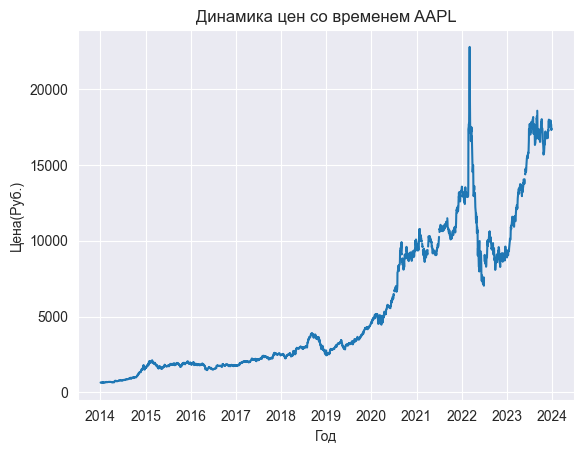

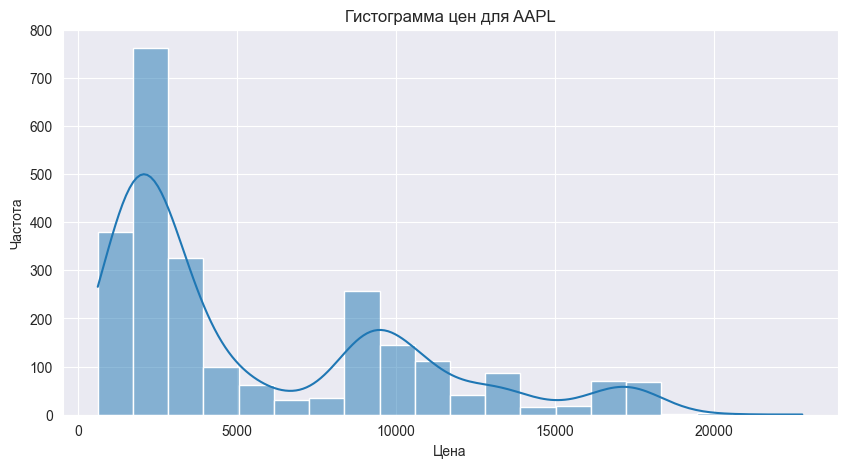

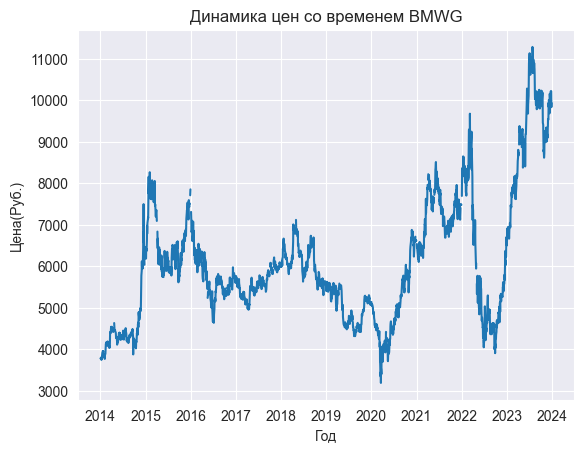

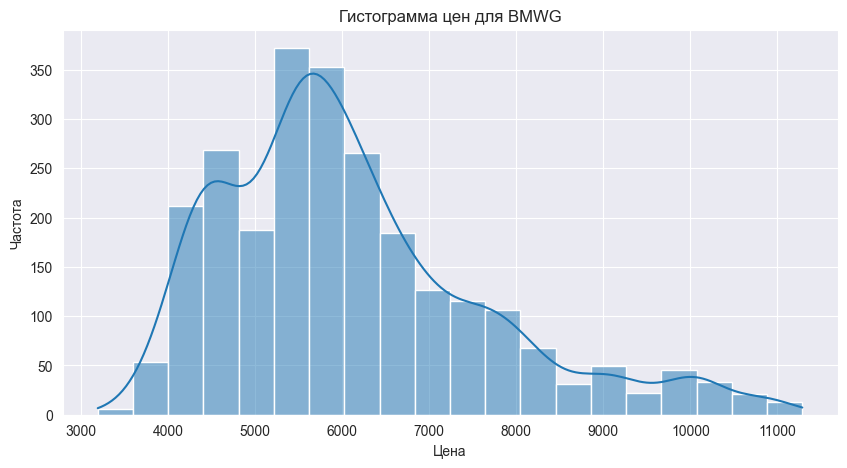

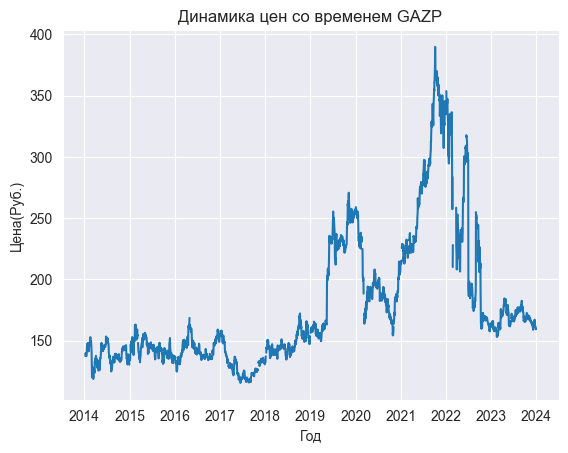

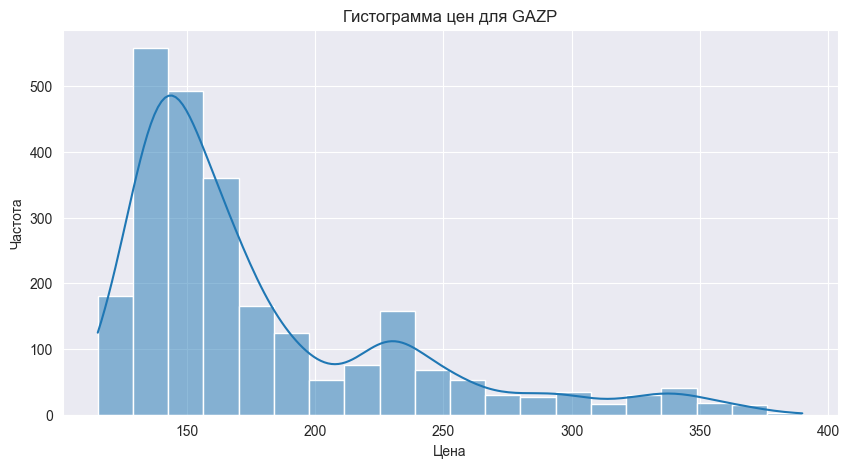

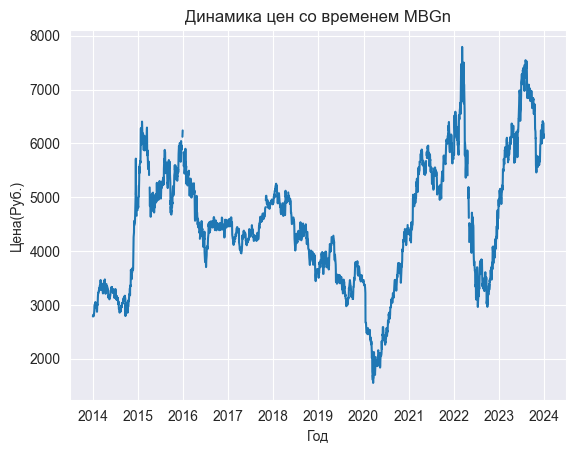

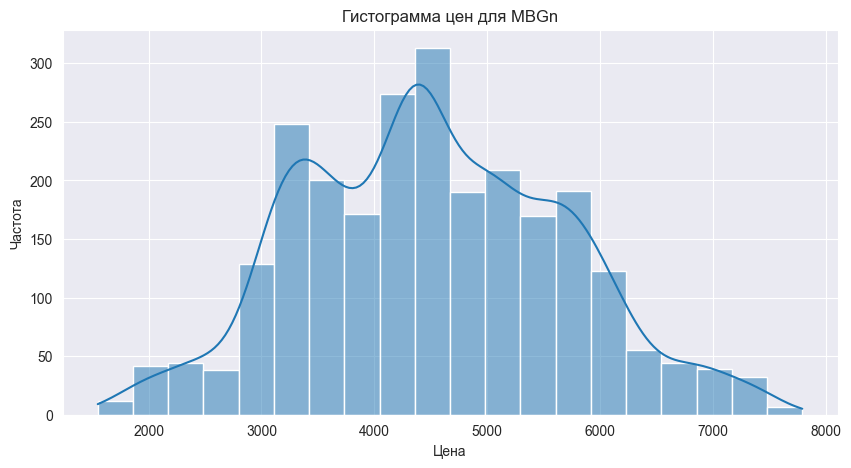

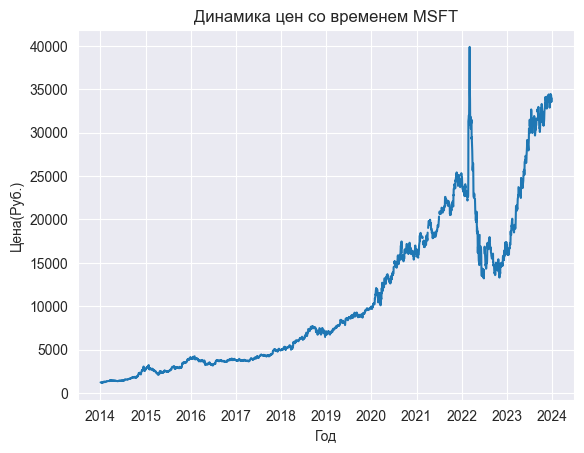

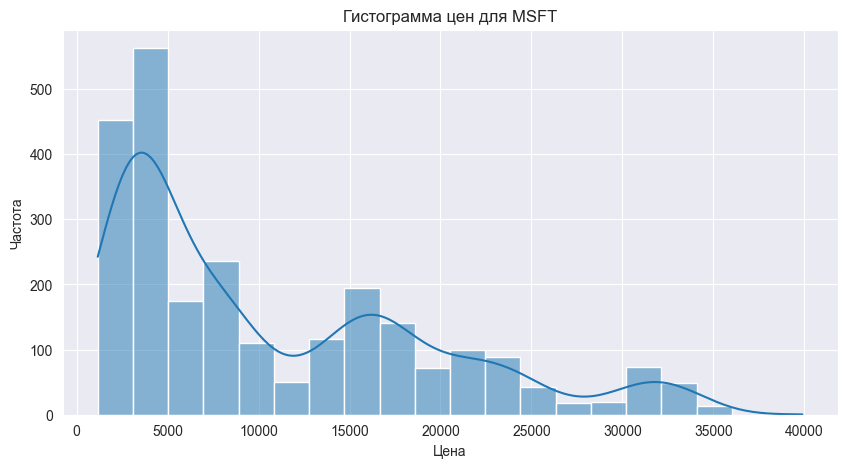

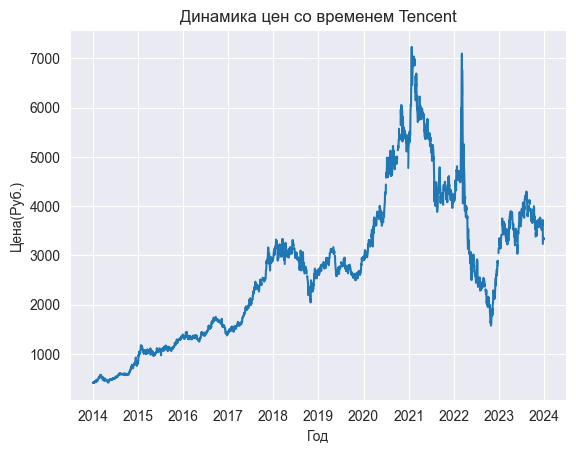

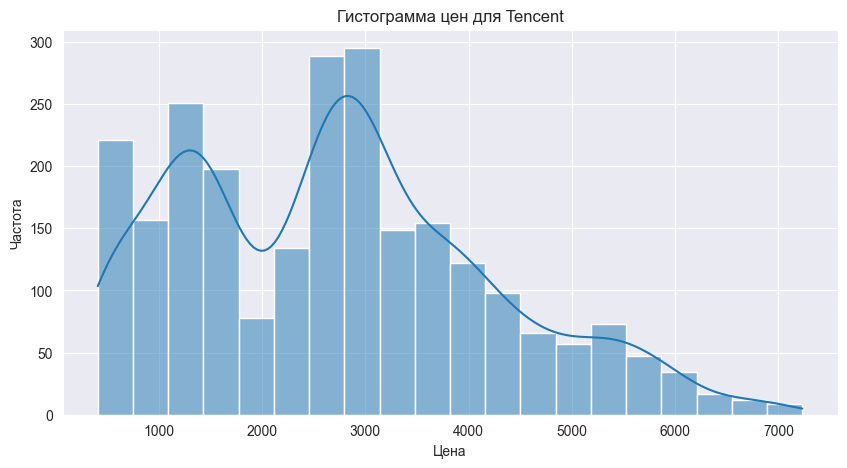

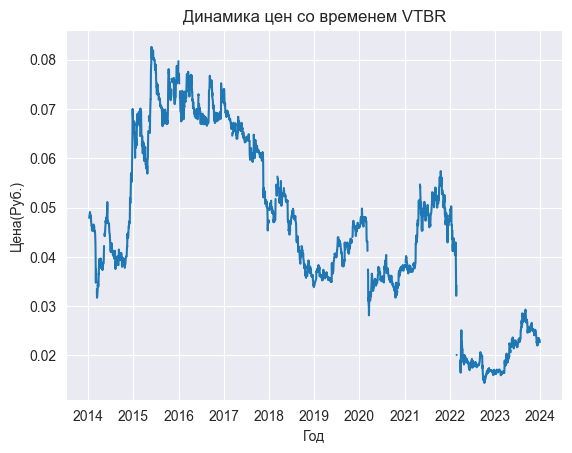

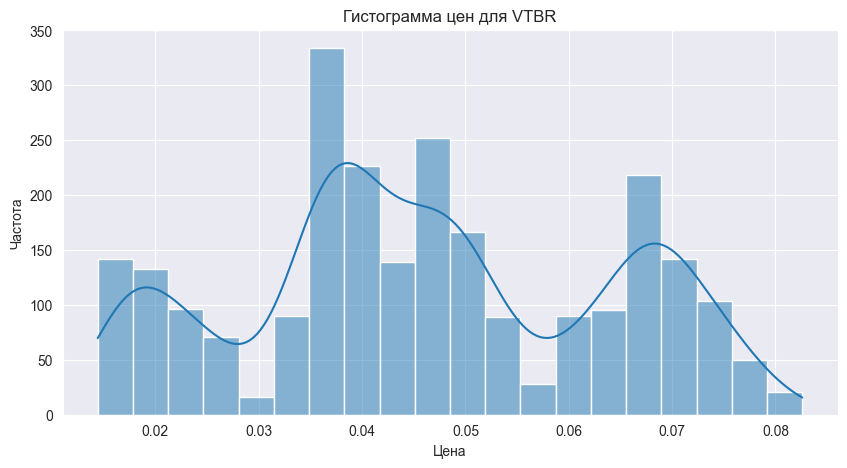

In [84]:
for column in df:
    plt.plot(df.index, df[column])
    plt.title(f'Динамика цен со временем {column}')
    plt.xlabel('Год')
    plt.ylabel('Цена(Руб.)')
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=column, bins=20, kde=True)
    plt.title(f'Гистограмма цен для {column}')
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    plt.show()
#вывод

Финансовые продукты описываются двумя характеристикам – __доходностью__ и __риском.__ Доходность – это процентное изменение стоимости за некоторый промежуток времени:

$$
R_t = \left( \frac{P_t}{P_{t-1}} - 1 \right) \cdot 100\%.
$$

Под риском обычно имеют в виду стандартное отклонение.


з)  Рассчитаем процентное изменение цены акций в рублях ото дня ко дню для `df`. Полученную таблицу доходностей сохраним в переменную `df_pct_change`.

__Hint__: С этим поможет метод `pct_change()`)

In [86]:
df_pct_change = df.pct_change()
for i in df_pct_change:
    df_pct_change[i]*=100
df_pct_change.head()

/var/folders/np/p8hkytk930zb8qkjtz4fk_6w0000gn/T/ipykernel_60770/1245734763.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct_change = df.pct_change()


,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN
2014-01-06,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN
2014-01-07,-0.929796,0.372260,0.000000,1.092773,0.562566,-0.531735,0.000000
2014-01-08,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957


и)  Для всех тикеров из таблички `df_pct_change` построем картинки с динамикой доходностей, гистограмму доходностей и ящики с усами.

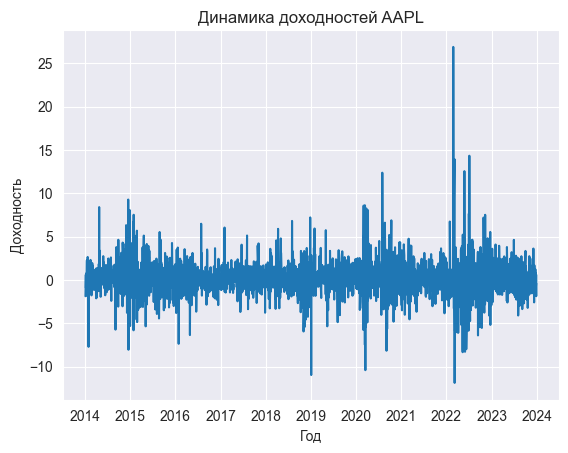

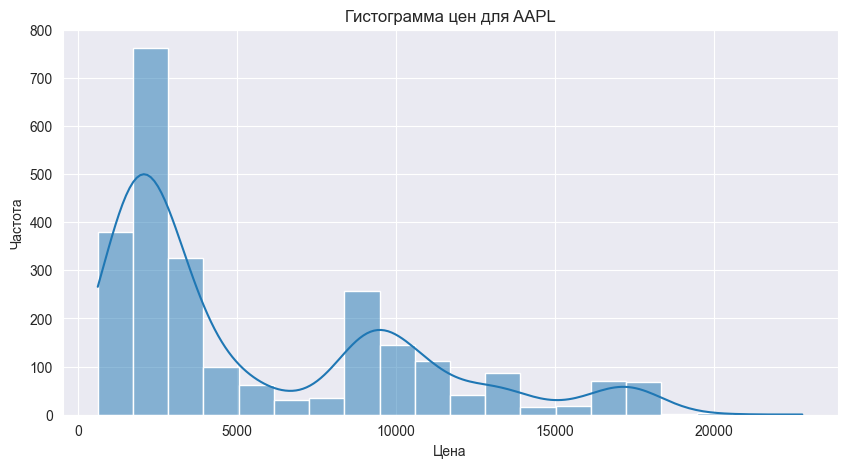

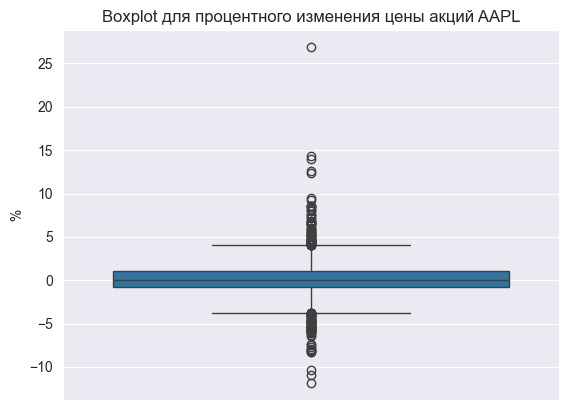

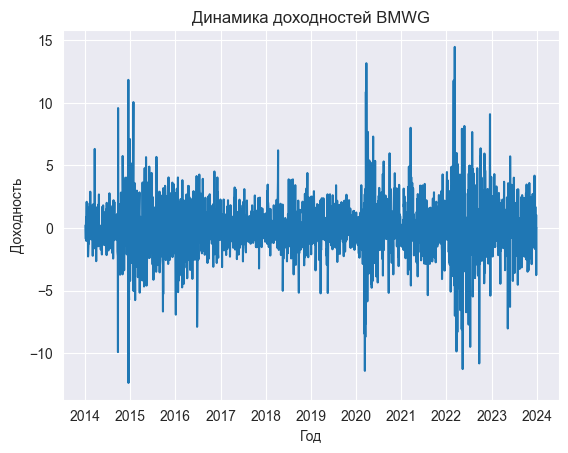

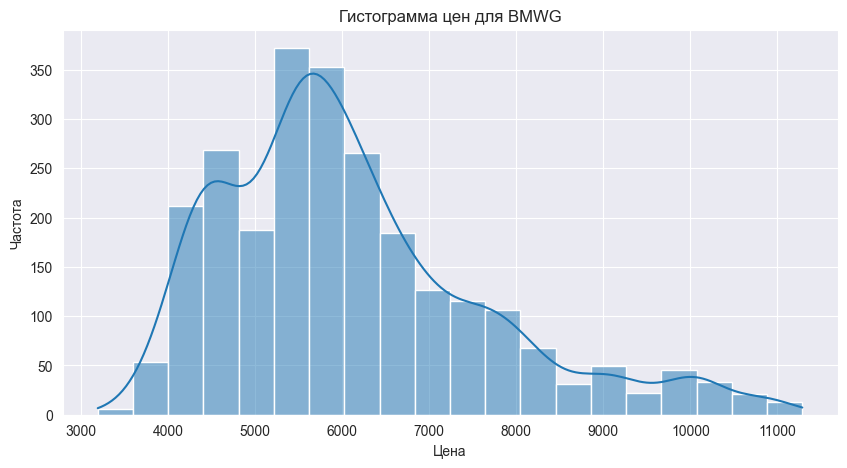

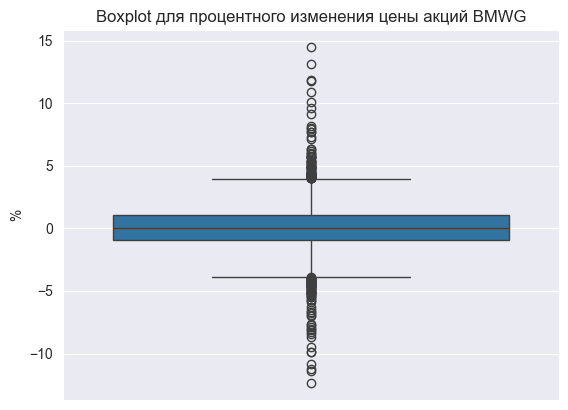

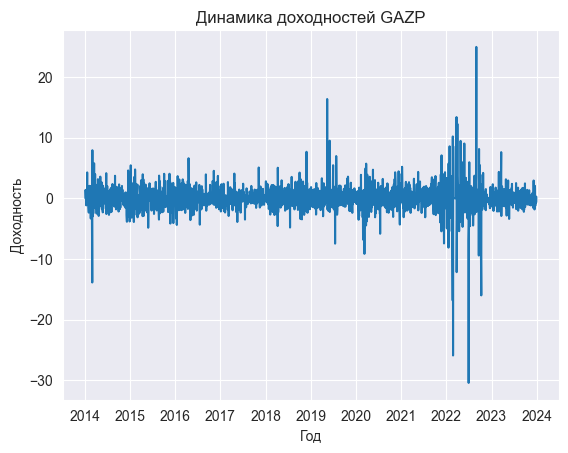

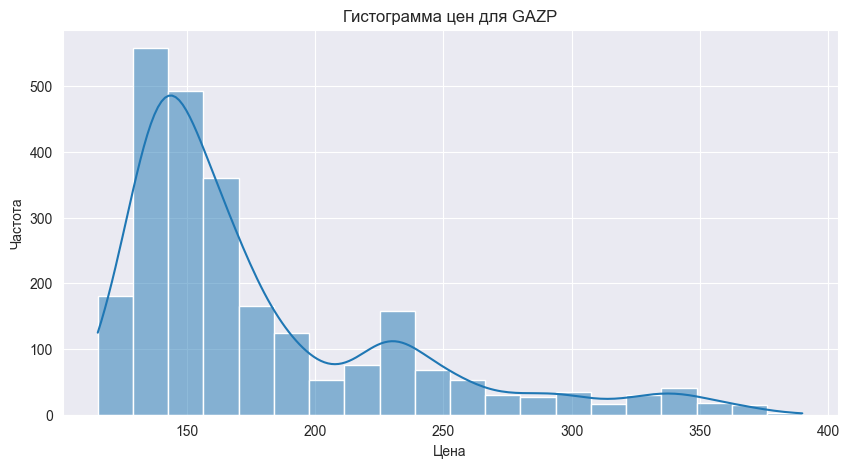

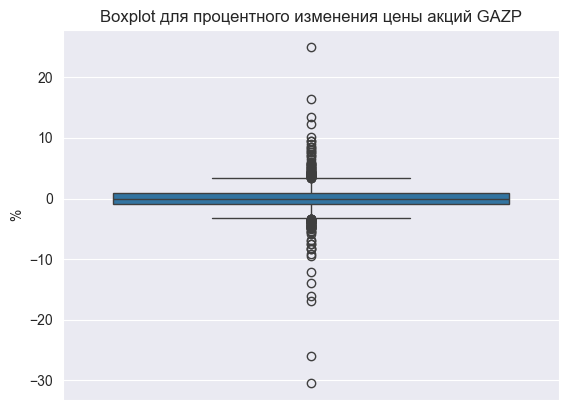

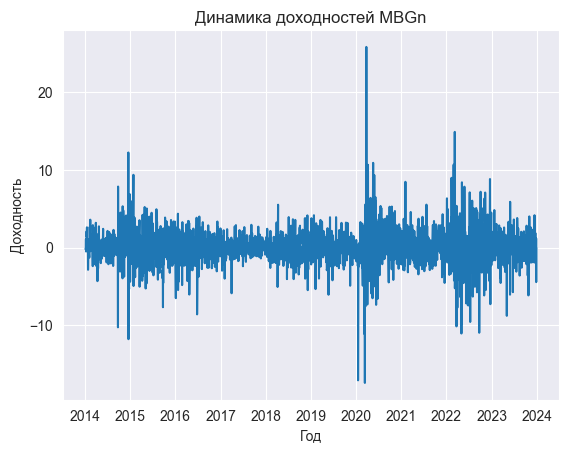

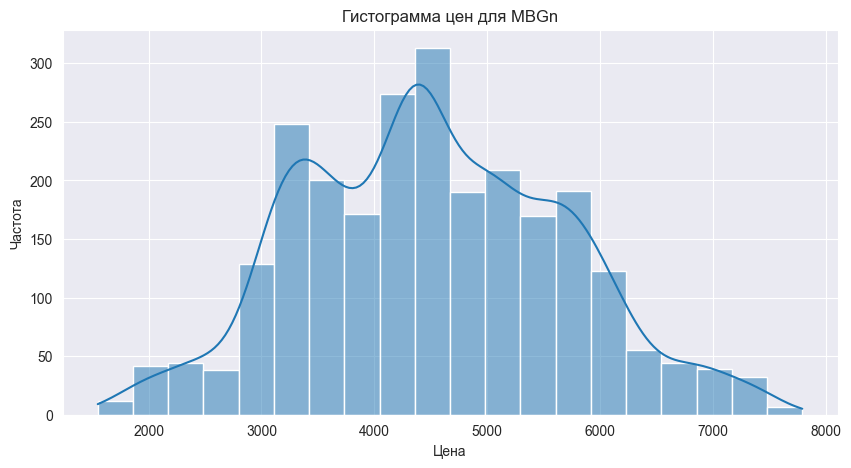

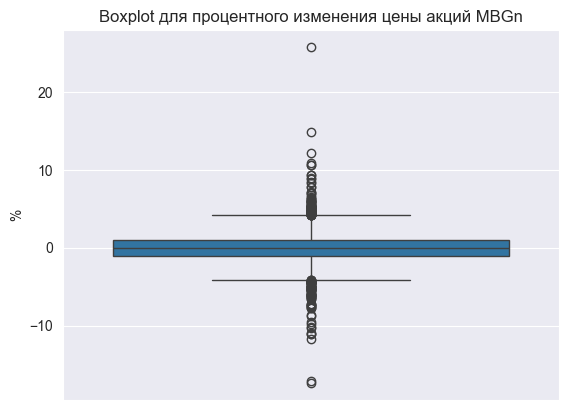

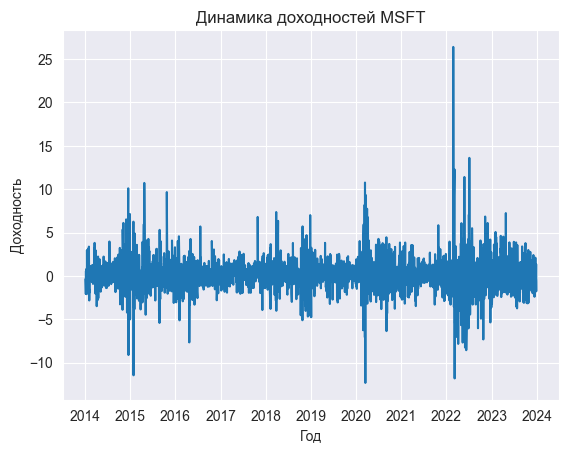

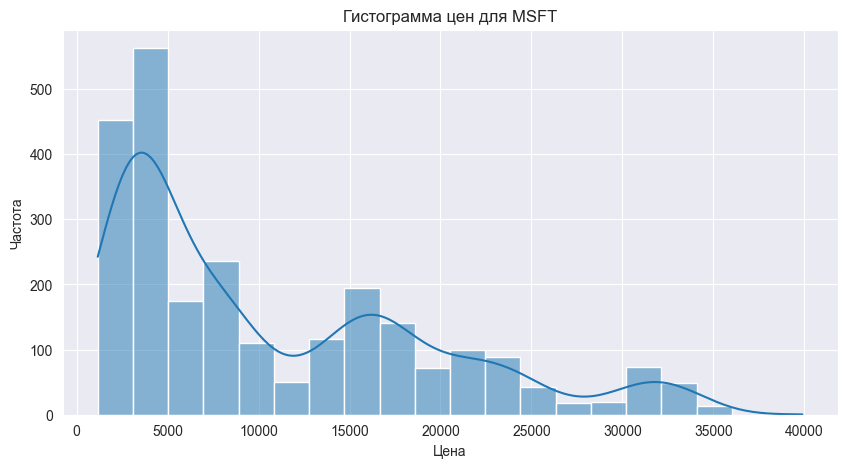

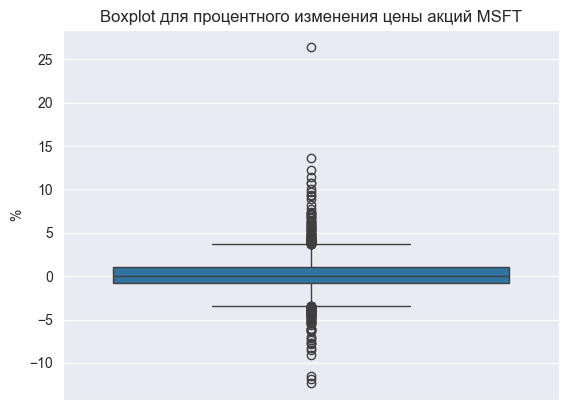

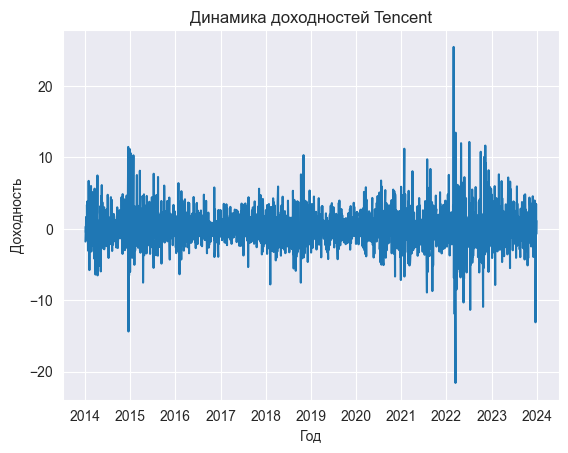

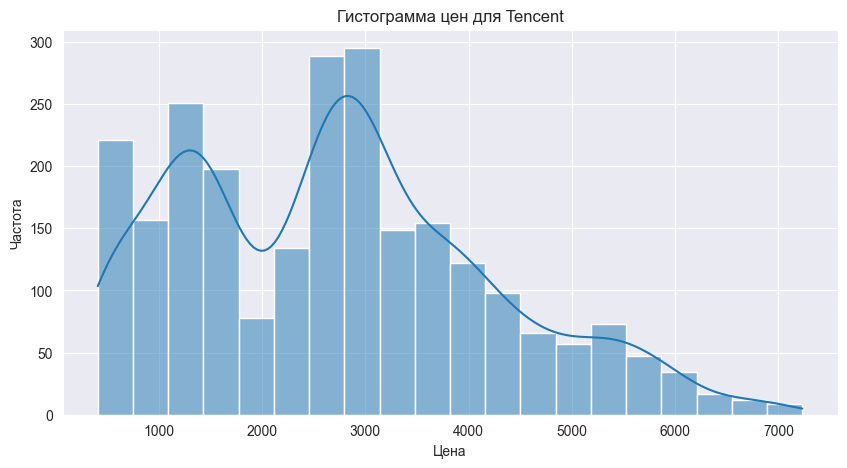

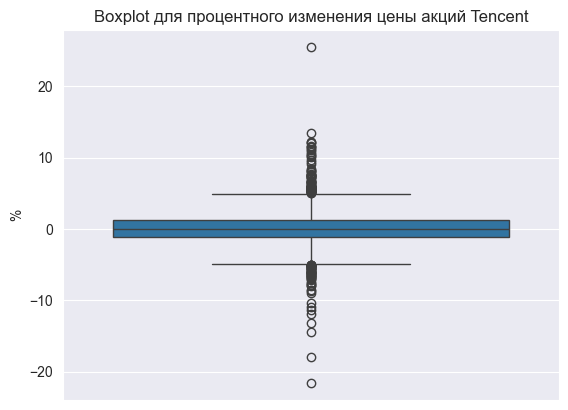

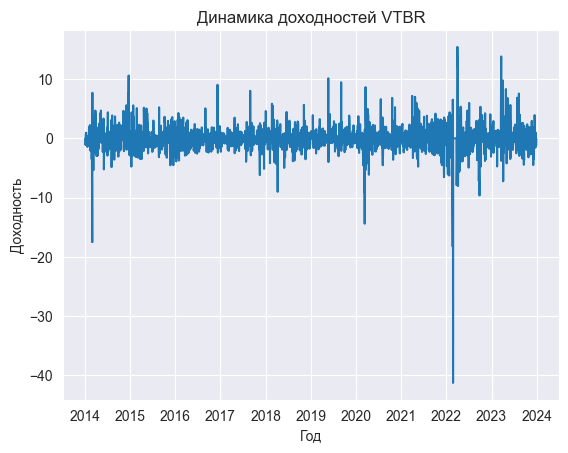

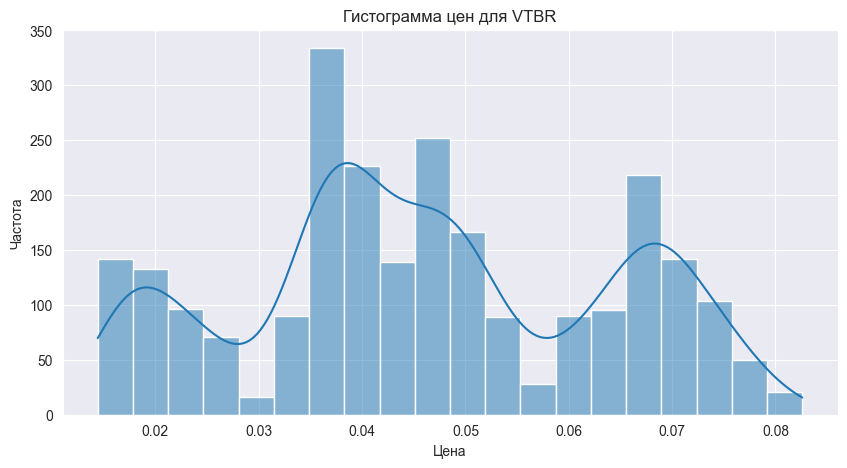

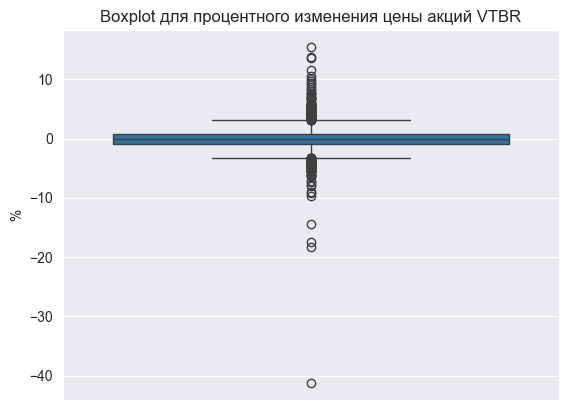

In [87]:
for column in df_pct_change:
    plt.plot(df_pct_change.index, df_pct_change[column])
    plt.xlabel('Год')
    plt.ylabel('Доходность')
    plt.title(f'Динамикa доходностей {column}')
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=column, bins=20, kde=True)
    plt.title(f'Гистограмма цен для {column}')
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    plt.show()
    sns.boxplot(data=df_pct_change[column])
    plt.title(f'Boxplot для процентного изменения цены акций {column}')
    plt.ylabel('%')
    plt.show()

 #Ответ на первый и второй вопрос   

к)  В пункте д) мы нашли даты, в которые наблюдались наибольшие измения стоимости ценых бумаг. При расчётах мы проигнорировали колебания курсов валют.

Давайте посмотрим, каким бы было колебание цен акций в абсолютном выражении для дат из таблички `top_5_diff`, если бы мы учли изменения курсов валют.

В таблице `df_pct_change` все доходности измерены в рублях. Посчитаем для этой таблицы построчное среднее для абсолютных значений изменений.

In [89]:
def absolute_mean(row):
    return row.abs().mean()
df_pct_change['abs_mean'] = df_pct_change.apply(absolute_mean, axis = 1)
df_pct_change.head()

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR,abs_mean
Дата,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN,0.887044
2014-01-06,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN,0.780805
2014-01-07,-0.929796,0.372260,0.000000,1.092773,0.562566,-0.531735,0.000000,0.498447
2014-01-08,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957,1.134081


Оставим только те даты, которые встречаются в `top_5_diff`, и добавим их в качестве нового столбца `'Изм. (RUB) %'`



In [90]:
for data in array_of_dates:
    data = str(data)
    top_5_diff.loc[data, 'Изм. (RUB) %'] = df_pct_change.loc[data, 'abs_mean']
top_5_diff
#Вывод

,Изм. %,Изм. (RUB) %
Дата,,
2022-02-24,13.081429,12.677837
2016-02-29,11.840000,1.631587
2020-03-24,10.795714,9.703503
2020-03-12,10.615714,9.19515
2022-02-21,9.128000,5.438385


## 3 Составляем портфель


Финансовые продукты описываются двумя характеристиками: __доходностью__ и __риском__.

Доходность — это процентное изменение стоимости за некоторый промежуток времени. Под риском, как правило, понимается стандартное отклонение доходности акций.

Однако когда речь идет о нескольких акциях в портфеле, то необходимо учитывать, как связана динамика цен на эти акции: падение доходности одной из акций может быть компенсировано ростом другой. Такой портфель будет предпочтительнее, поскольку предлагает меньшие риски для инвестора.

Осталось найти то самое сладкое сочетание активов... Для поиска оптимальных весов активов в портфеле обычно решается __задача оптимизации.__

Мы поступим проще:

- Будем рассматривать портфель, состоящий всего из 2 тикеров: `'AAPL'` и `'Tencent'`.
- Наилучшее сочетание весов будем искать неоптимальным способом, тупо перебирая различные варианты.

Пусть мы вкладываем долю нашего бюджета $w$ в первую ценную бумагу, а долю $(1 - w)$ во вторую. Тогда ожидаемая доходность порфеля составит

$$
\mathbb{E}(R) = w \cdot \mathbb{E}(R_1)  + (1 - w) \cdot \mathbb{E}(R_2).
$$

Дисперсия портфеля будет равна

$$
\text{Var}(R) = w^2 \cdot \text{Var}(R_1)  + (1 - w)^2 \cdot \text{Var}(R_2) + 2 \cdot w \cdot \text{Cov}(R_1, R_2).
$$

Ковариацию, по её определению, можно переписать как

$$
\text{Cov}(R_1, R_2) = \text{Corr}(R_1, R_2) \cdot \sigma(R_1) \cdot \sigma(R_2),
$$

где $\sigma(R_i) = \sqrt{ \text{Var}(R_i)}$.


Для начала создадим веса, которые будем рассматривать.

а) С помощью функции `np.arange()` создайте `array` от $0$ до $1$ с шагом $0.01$)

In [91]:
w = np.arange(0,1,0.01)

Теперь запишем необходимые характеристики акций в соответствующие переменные:

б) В переменные `r1` и `r2` сохраним среднюю доходность акций `'AAPL'` и `'Tencent'` из `df_pct_change`. Убедимся, что доходности представлены не в процентах, а в виде чисел. Например не $10\%$, а $0.1$.

Кроме того, поскольку стандартной мерой доходности является годовая доходность, преобразуем среднюю ежедневную доходность в годовую, используя формулу сложного процента для полученных значений:

$$
r_{\text{год}} = (1 + r_{\text{день}})^{252} - 1,
$$

где:
- $r_{\text{год}}$ - ожидаемая годовая доходность,
- $r_{\text{день}}$ - средняя ежедневная доходность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

In [93]:
r1_day = df_pct_change['AAPL'].div(100).mean()
print(r1_day)
r2_day = df_pct_change['Tencent'].div(100).mean()
print(r2_day)
r1_year = (r1_day+1)**252 -1
print(r1_year)
r2_year = (r2_day+1)**252 -1
r2_year

0.001475107790900633
0.0011308938501601818
0.4498400845173225


0.3295283131928597

в) Аналогично сохраним стандартные отклонения доходности этих акций в `sd1` и `sd2`. Преобразуем эти значения из дневных в годовые:

$$
\sigma_{\text{год}} = \sigma_{\text{день}} \times \sqrt{252}
$$

Где:
- $\sigma_{\text{год}}$ - годовая волатильность,
- $\sigma_{\text{день}}$ - ежедневная волатильность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

Эта формула основана на предположении, что ежедневные доходности распределены независимо и одинаково. В реальности рыночные условия могут влиять на точность этого преобразования, но это общепринятый метод для оценки годовой волатильности на основе ежедневных данных.

In [94]:
sd1_day = np.sqrt(df_pct_change['AAPL'].div(100).var())
print(sd1_day)
sd2_day = np.sqrt(df_pct_change['Tencent'].div(100).var())
print(sd2_day)
sd1_year = sd1_day * np.sqrt(252)
sd2_year = sd2_day * np.sqrt(252)
print(sd1_year)
print(sd2_year)

0.020886353356630766
0.02577764751374949
0.331560580659985
0.40920746823398163


в) В переменную `rho` сохраним корреляцию между акциями.

In [95]:
rho = (df_pct_change['AAPL'].div(100).corr(df_pct_change['Tencent'].div(100)))
rho

0.26314132158240405

Теперь посчитаем доходность и волатильность портфеля, используя соответствующие формулы

In [96]:
r_p2 = w * r1_year +(1 - w) * r2_year * 100
sd_p2 = np.sqrt(w**2 * sd1_year**2 + (1 - w)**2 * sd2_year**2 + 2 * w * (1 - w) * rho * sd1_year * sd2_year) * 100
print(r_p2)
print(sd_p2)

[32.95283132 32.62780141 32.30277149 31.97774158 31.65271167 31.32768176
 31.00265185 30.67762193 30.35259202 30.02756211 29.7025322  29.37750228
 29.05247237 28.72744246 28.40241255 28.07738263 27.75235272 27.42732281
 27.1022929  26.77726298 26.45223307 26.12720316 25.80217325 25.47714334
 25.15211342 24.82708351 24.5020536  24.17702369 23.85199377 23.52696386
 23.20193395 22.87690404 22.55187412 22.22684421 21.9018143  21.57678439
 21.25175447 20.92672456 20.60169465 20.27666474 19.95163483 19.62660491
 19.301575   18.97654509 18.65151518 18.32648526 18.00145535 17.67642544
 17.35139553 17.02636561 16.7013357  16.37630579 16.05127588 15.72624596
 15.40121605 15.07618614 14.75115623 14.42612632 14.1010964  13.77606649
 13.45103658 13.12600667 12.80097675 12.47594684 12.15091693 11.82588702
 11.5008571  11.17582719 10.85079728 10.52576737 10.20073745  9.87570754
  9.55067763  9.22564772  8.90061781  8.57558789  8.25055798  7.92552807
  7.60049816  7.27546824  6.95043833  6.62540842  6

г) Построим линейный график в осях (`sd_p2`, `r_p2`)



Text(0, 0.5, 'Expected Return (%)')

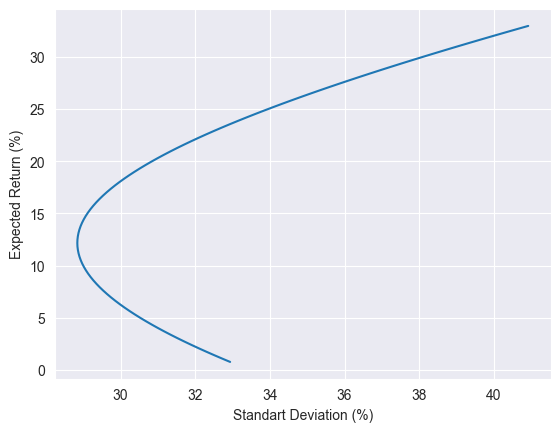

In [97]:
plt.plot(sd_p2, r_p2)
plt.xlabel('Standart Deviation (%)')
plt.ylabel('Expected Return (%)')

Получившаяся у вас картинка должна быть похожа на такую:

<center>
<img src="https://investprofit.info/wp-content/uploads/2018/08/Frontier1.png" height="450">
</center>

В портфельной теории Марковица эта кривая называется эффективной границей (или кривой эффективностию). Её можно поделить на три зоны:

- **Эффективная граница (Efficient Frontier)** — это часть кривой, которая лежит выше портфеля с минимальной дисперсией (риском). Портфели на этом участке предлагают наилучшее сочетание риска и доходности. Другими словами, для любого данного уровня риска, портфели на эффективной границе предлагают максимальную возможную доходность.
- **Портфели ниже эффективной границы** считаются неэффективными, так как для того же уровня риска можно добиться большей доходности.
- **Портфели выше эффективной границы** обычно не существуют, так как они предполагали бы получение более высокой доходности при том же уровне риска.

Найдем портфель с минимальной дисперсией (риском).

д) Для этого сначала создадим табличку со столбцами `'Вес'`, `'Риск'` и `'Доходность'` (содержащими `w`, `sd_p2` и `r_p2` соответственно)

In [99]:
df_r =pd.DataFrame({'Вес':w, 'Риск(%)':sd_p2, 'Доходность(%)': r_p2} )
df_r.head()

,Вес,Риск(%),Доходность(%)
0,0.00,40.920747,32.952831
1,0.01,40.600047,32.627801
2,0.02,40.281907,32.302771
3,0.03,39.966389,31.977742
4,0.04,39.653554,31.652712


е) Теперь найдем портфель с минимальным риском и запишем его в переменную `min_sd_p`, а само значение минимального риска в `min_sd`

In [100]:
min_sd = df_r['Риск(%)'].div(100).min()
min_sd_p = df_r[df_r['Риск(%)'].div(100) == min_sd]
min_sd_p

,Вес,Риск(%),Доходность(%)
64,0.64,28.841208,12.150917


ж) Выберем множество эффективных портфелей из `df_r`, тех, чья доходность и риск выше, чем у `min_sd_p` и сохраним их в `df_eff_p`

In [103]:
df_eff_p = df_r[(df_r['Доходность(%)'] > min_sd_p['Доходность(%)'].values[0]) & (df_r['Риск(%)'] > min_sd_p['Риск(%)'].values[0])]
df_eff_p.head()

,Вес,Риск(%),Доходность(%)
0,0.00,40.920747,32.952831
1,0.01,40.600047,32.627801
2,0.02,40.281907,32.302771
3,0.03,39.966389,31.977742
4,0.04,39.653554,31.652712


з) А теперь на основе `df_eff_p` построим эффективную границу, о которой шла речь раньше (часть кривой выше портфеля с наименьшей волатильностью)

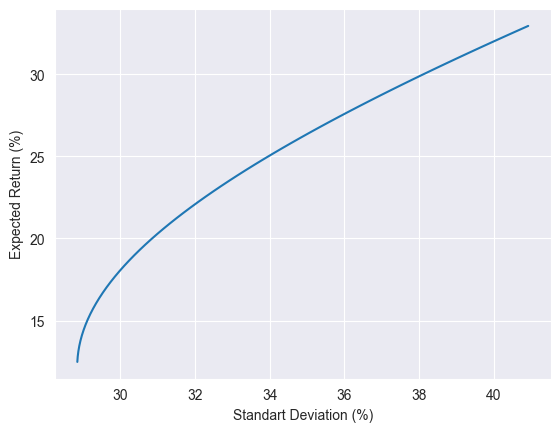

In [104]:
plt.plot(df_eff_p['Риск(%)'], df_eff_p['Доходность(%)'])
plt.xlabel('Standart Deviation (%)')
plt.ylabel('Expected Return (%)')
plt.show()

Выше мы говорили, что для поиска оптимального портфеля необходимо решать задачу оптимизации. Целевую функцию для её решения можно определить по-разному. Выше мы занимались минимизацией риска и нашли `min_sd_p`.

Кроме минимизации риска можно попытаться максимизировать **коэффициент Шарпа.** Он рассчитывается по формуле

$$
SR = \frac{r_{p} - r_{f}}{\sigma_{p}},
$$

где $r_{p}$  —  ожидаемая доходность портфеля, $r_{f}$  —  безрисковая ставка доходности, $\sigma_{p}$ — стандартное отклонение доходности портфеля.

Коэффициент Шарпа отражает премию за принятый риск. Любая инвестиционная стратегия, демонстрирующая более крутой наклон кривой Шарпа, предлагает более высокую ожидаемую доходность для данного уровня риска. Следовательно, более высокий коэффициент Шарпа всегда предпочтительнее, независимо от того, какой уровень риска вы готовы принять.

In [105]:
r_f = 11.8 / 100

и) Теперь у нас есть возможность рассчитать коэффициент Шарпа для кадждого портфеля в `df_r`. Для этого необходимо вычесть из доходности портфеля безрисковую ставку (`r_f`) и разделить на волатильность (риск) портфеля. Сохраните полученные значения в столбец `'Sharp'` таблицы `df_r`

In [107]:
df_r['Sharp'] = (df_r['Доходность(%)'].div(100) - r_f) / df_r['Риск(%)'].div(100)
df_r.head()

,Вес,Риск(%),Доходность(%),Sharp
0,0.00,40.920747,32.952831,0.516922
1,0.01,40.600047,32.627801,0.512999
2,0.02,40.281907,32.302771,0.508982
3,0.03,39.966389,31.977742,0.504868
4,0.04,39.653554,31.652712,0.500654


и) Определим портфель с максимальным коэффициентом Шарпа, сохраните его в переменную `max_sharp_p`, а значение самого коэффициента - в переменную `max_sharp`

In [109]:
max_sharp = df_r['Sharp'].max()
max_sharp_p = df_r[df_r['Sharp'] == max_sharp]
max_sharp_p

,Вес,Риск(%),Доходность(%),Sharp
0,0.0,40.920747,32.952831,0.516922


Рассмотрим прямую в осях (Риск - Доходность), выраженную формулой

$$ r = max\_sharp \cdot \sigma + r_f $$

Для того, чтобы ее провести, нам необходимо задать хотя бы 2 точки. Чтобы построенный график хорошо выглядел, рассмотрим $\sigma$, равную:

1. наименьшему значению риска портфелей на эффективной кривой (`min_sd`)
2. значению риска, соответствующего портфелю с наибольшим значением коэффициента Шарпа (из `max_sharp_p`)

к) В переменную `sigma` сохраните `numpy.array` с двумя перечисленными выше значениями

In [110]:
sigma = np.array([min_sd, max_sharp])
sigma

array([0.28841208, 0.51692193])

л) В переменную `r` сохраним значения доходности, находящиеся на указанной прямой, для значений риска из `sigma` (необходимо использовать формулу прямой)

In [111]:
r = max_sharp * sigma + r_f
r

array([0.26708653, 0.38520828])

м) Теперь построим эффективную границу, что мы уже делали ранее, и проведем указанную прямую (вернее ее часть).

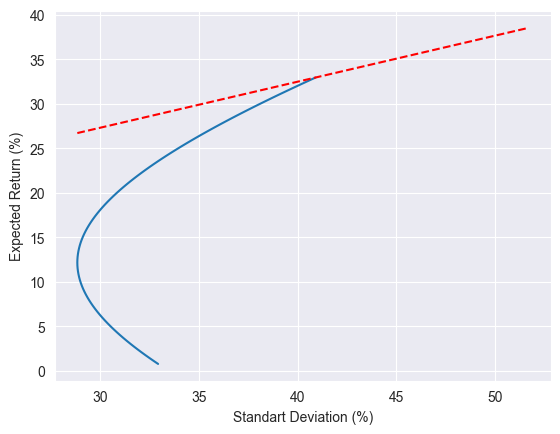

In [112]:
plt.plot(df_r['Риск(%)'], df_r['Доходность(%)'])
plt.plot(sigma*100, r*100, color='red', linestyle='--')
plt.xlabel('Standart Deviation (%)')
plt.ylabel('Expected Return (%)')
plt.show()

Полученная прямая является касательной к эффективной кривой, а точка ее касания представляет собой так называемый тангенциальный портфель.

Каждая точка на прямой Шарпа представляет собой портфель, состоящий из комбинации безрискового актива (в нашем случае, государственных облигаций) и рыночного портфеля (здесь, сочетание двух акций).

Все портфели на прямой Шарпа считаются эффективными в смысле оптимального соотношения риска и доходности. Это означает, что для любого данного уровня риска портфель на этой линии предоставляет максимально возможную доходность.

Таким образом, мы немного углубились в портфельную теорию и рассмотрели 2 основных метода оптимизации структуры портфеля:
- поиск наименее волатильного (рискового) портфеля
- поиск портфеля с оптимальным соотношением доходности и риска.